This notebook is a step by step guide about how to train a deep neural network (DNN) in the DeepDeconv framework.

In [1]:
## Set up the sys.path in order to be able to import our modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import keras.utils

Using TensorFlow backend.


In [2]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k

###################################
# TensorFlow wizardry
config = tf.ConfigProto()
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True

# Only allow a total of half the GPU memory to be allocated
# This line is optional, don't add it unless you really need to set a limit on the memory available for your process
# For instance, if you want to train 2 DNNs on the same GPU without one overlapping the memory needed by the other
# Change the value to set the percentage of memory allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5 

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

# Now you can create/load your DNN

In [3]:
#from DeepDeconv.deepnetFCS.DeconvNet import DeconvNet

In [4]:
from deepnetFCS.DeconvNet_custom import UNet2D
nb_scales = 3 #4
nb_layers_per_block =  [4,4,4] #[2,2]#,2] #[4,5,6,7]
nb_filters=16
activation_function= 'relu' #'swish'
resNet=False
layer_string='layer{0}'.format(nb_layers_per_block[0])
atrou=True

for k in range(1,len(nb_layers_per_block)):
    layer_string+='x{0}'.format(nb_layers_per_block[k])
network_name='UNet2D_FCS_sc{0}_{1}_{2}_filt{3}'.format(nb_scales,layer_string,activation_function,nb_filters)
if atrou:
    network_name+='_atrou'
if resNet:
    network_name+='_resNet'

print("Network Name:",network_name)
    
dnn = UNet2D(network_name = network_name, img_rows = 96, img_cols = 96, model_file='', verbose=True,
                filters=nb_filters,nb_scales=nb_scales, nb_layers_per_block=nb_layers_per_block, 
             activation_function=activation_function,resNet=resNet,atrou=atrou)


Network Name: UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 16)   144         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 16)   0           batch_normalization_1[0][0]      
___________________________________________________

In [5]:
from keras.utils import plot_model
plot_model(dnn.model, to_file='{0}.png'.format(network_name),show_shapes=True)

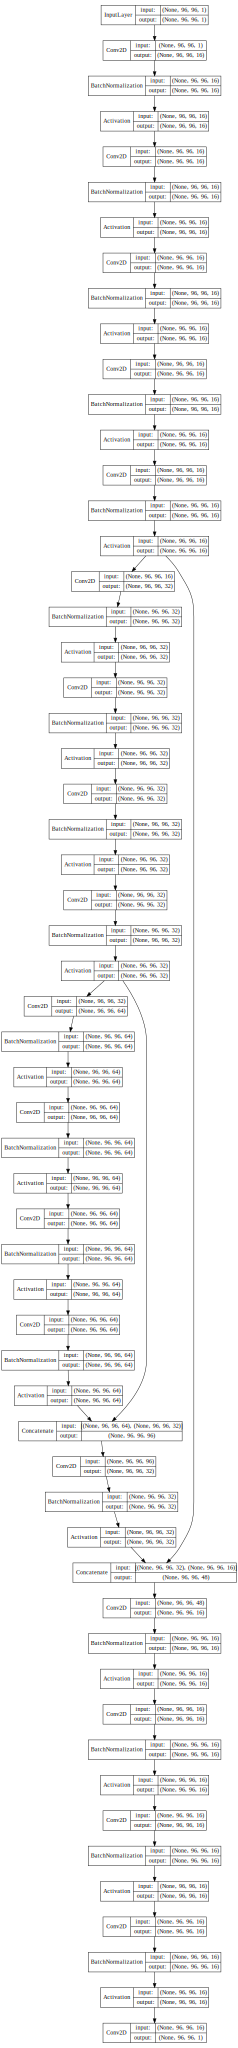

In [6]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

pydot_obj=model_to_dot(dnn.model,show_shapes=True,show_layer_names=False)
SVG(pydot_obj.create(prog='dot', format='svg'))

## PREPROCESSING OF DATA

In [7]:
# from astropy.io import fits as fits
# from matplotlib import pyplot as plt
# #Input the directory containing the fits file
# data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/'

# #Retrieves the list of all the files
# import glob

# gal_files = glob.glob(data_directory+'image-0*-0.fits')
# gal_files.sort()
# print(gal_files)

# import numpy as np

# from utils.batch_utils import shuffle_new_fits

# data_reshfl_dir=data_directory+"reshuffle/"
# noiseless_img_hdu = 1
# targets_hdu = 4
# psf_hdu = 3
# rootname_reshfl=data_reshfl_dir+"image-shfl"
# np.random.seed(2012)
# shuffle_new_fits(gal_files, nb_img_per_file=10000,
#                         noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
#                         image_dim=96, image_per_row=100,rootname=rootname_reshfl)


In [12]:
# from astropy.io import fits as fits
# from matplotlib import pyplot as plt
# ff=fits.open(gal_files[0])
# plt.figure()
# for k in range(5):
#     plt.subplot(2,3,k+1),plt.imshow(ff[k].data[0:96,0:96])
# #HDU 0: noisy
# #HDU 1: noise free convolved with euclid PSF
# #HDU 2: noise free convolved with large PSF (gauss 0.15 FWHM)
# #HDU 3: euclid PSF
# #HDU 4: noise free convolved with target PSF (gauss 0.07 FWHM)
# plt.figure()
# plt.imshow(ff[1].data[0:96,0:96]-ff[4].data[0:96,0:96])

NameError: name 'gal_files' is not defined

## Training Phase

In [7]:
import glob
import numpy as np
from astropy.io import fits as fits
from matplotlib import pyplot as plt
data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/'

SNR = [20,100]
if len(SNR)==1:
    old_dnn_name=dnn.network_name
    dnn.network_name+='_reshfl_SNR{0}'.format(SNR[0])
else:
    old_dnn_name=dnn.network_name
    dnn.network_name+='_reshfl_SNR{0}to{1}'.format(SNR[0],SNR[1])
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2
deconv_mode = 'TIKHONOV'
data_reshfl_dir=data_directory+"reshuffle/"
gal_files_shfl = glob.glob(data_reshfl_dir+'image-shfl-*-multihdu.fits')
gal_files_shfl.sort()

print(gal_files_shfl)
print(dnn.network_name)

#Train with the image-000-0.fits as validation and all the other files as training set
dnn.train_generator(gal_files_shfl[2:], gal_files_shfl[1], epochs=20, batch_size=32,
                        nb_img_per_file=10000, validation_set_size=10000,
                        noise_std=None, SNR=SNR, model_file='',
                        noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
                        image_dim=96, image_per_row=100,
                        deconv_mode=deconv_mode)

dnn.network_name=old_dnn_name

['/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-0-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-1-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-10-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-11-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-12-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-13-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-14-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-15-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-16-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-17-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-18-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-19-multihdu.fits', '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/image-shfl-2-mult

/home/fsureau/programs/DeepDeconv/deepnet/DeepNet.py:133: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=20, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=5947)`
  callbacks=[model_checkpoint, LoggingCallback(filetxt=logfile, log=write_log)])


Epoch 1/20
5947/5947 [==============================] - 2753s 463ms/step - loss: 0.0015 - val_loss: 3.3136e-04

Epoch 00001: val_loss improved from inf to 0.00033, saving model to UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100.hdf5
2019-02-01_17:58:31 - Epoch: 1, val_loss: 0.000331, loss: 0.001518
Epoch 2/20
5947/5947 [==============================] - 2334s 392ms/step - loss: 2.4942e-04 - val_loss: 2.4086e-04

Epoch 00002: val_loss improved from 0.00033 to 0.00024, saving model to UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100.hdf5
2019-02-01_18:37:25 - Epoch: 2, val_loss: 0.000241, loss: 0.000249
Epoch 3/20
5947/5947 [==============================] - 2273s 382ms/step - loss: 2.3027e-04 - val_loss: 2.2275e-04

Epoch 00003: val_loss improved from 0.00024 to 0.00022, saving model to UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou_reshfl_SNR20to100.hdf5
2019-02-01_19:15:19 - Epoch: 3, val_loss: 0.000223, loss: 0.000230
Epoch 4/20
5947/5947 [====================

In [8]:
len(SNR)

2

In [9]:
dnn.network_name

'UNet2D_FCS_sc3_layer4x4x4_relu_filt16_atrou'

In [21]:
#
#SNR=100

# noiseless_img_hdu = 1
# targets_hdu = 4
# psf_hdu = 3
# deconv_mode = 'TIKHONOV'

# #Train with the image-000-0.fits as validation and all the other files as training set
# dnn.train_generator(gal_files[2:], gal_files[1], epochs=20, batch_size=32,
#                         nb_img_per_file=10000, validation_set_size=10000,
#                         noise_std=None, SNR=SNR, model_file='',
#                         noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu, psf_hdu=psf_hdu,
#                         image_dim=96, image_per_row=100,
#                         deconv_mode=deconv_mode)

#The train_generator is:
#1) running get_batch_from_fits for validation data: read files, deconv if necessary, return as [ngal,X2D,Y2D,1]
#2) setting a checkpoint for model, saving the model if lower validation loss
#3) using a generator function to obtain dynamic batches: dynamic_batches 
#   that I modified because it was assuming nb_img_per_file to be 10000 (hardcoded)
#4) running fit_generator with logging and checkpoint callbacks 

#I modified 


Model will be saved at /home/fsureau/programs/DeepDeconv/UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet.hdf5
Memory usage for the model + one batch (GB): 0.881000


/home/fsureau/programs/DeepDeconv/deepnet/DeepNet.py:133: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., epochs=20, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=5947)`
  callbacks=[model_checkpoint, LoggingCallback(filetxt=logfile, log=write_log)])


Epoch 1/20
5947/5947 [==============================] - 2227s 374ms/step - loss: 8.3007e-04 - val_loss: 2.3895e-04

Epoch 00001: val_loss improved from inf to 0.00024, saving model to UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet.hdf5
2019-01-11_16:11:34 - Epoch: 1, val_loss: 0.000239, loss: 0.000831
Epoch 2/20
5947/5947 [==============================] - 1488s 250ms/step - loss: 2.0572e-04 - val_loss: 1.8464e-04

Epoch 00002: val_loss improved from 0.00024 to 0.00018, saving model to UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet.hdf5
2019-01-11_16:36:23 - Epoch: 2, val_loss: 0.000185, loss: 0.000206
Epoch 3/20
5947/5947 [==============================] - 1523s 256ms/step - loss: 1.8142e-04 - val_loss: 1.7455e-04

Epoch 00003: val_loss improved from 0.00018 to 0.00017, saving model to UNet2D_FCS_sc3_layer4x4x4_relu_filt16_resNet.hdf5
2019-01-11_17:01:46 - Epoch: 3, val_loss: 0.000175, loss: 0.000181
Epoch 4/20
5947/5947 [==============================] - 1466s 246ms/step - loss: 1.7367e-